# Import Packages

In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
print(tf.__version__)


2.5.0


# Utility Functions

In [4]:
def plotSeries(time, series, format="-", start = 0, end = None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [5]:
def trend(time, slope=0 ):
    return slope* time

In [6]:
def seasonalPattern(seasonTime):
    return np.where(seasonTime < 0.4, np.cos(seasonTime * 2 * np.pi), 1/np.exp(3*seasonTime))

In [7]:
def seasonality(time, period, amplitude=1, phase=0):
    seasonTime = ((time + phase) % period) / period
    return amplitude * seasonalPattern(seasonTime)

In [8]:
def noise(time, noiseLevel = 1, seed=99):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noiseLevel


In [9]:
def windowDataset(series, windowSize, batchSize, shuffleBuffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(windowSize + 1, shift=1, drop_remainder = True)
    dataset = dataset.flat_map(lambda window: window.batch(windowSize + 1))
    dataset = dataset.shuffle(shuffleBuffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batchSize).prefetch(1)
    return dataset

# The Series

In [10]:
time = np.arange(4*365 + 1, dtype="float32")
baseline = 10
amplitude = 40
noiseLevel = 5
slope = 0.05

In [11]:
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude = amplitude)
series+= noise(time, noiseLevel)

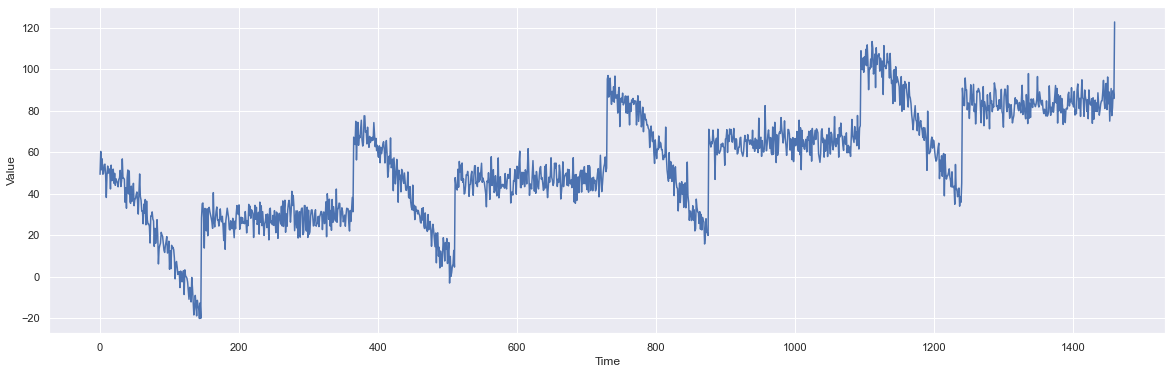

In [12]:
plt.figure(figsize=(20, 6))
plotSeries(time, series)
plt.show()

## The Split

In [13]:
splitTime = 1000
timeTrain = time[:splitTime]
xTrain = series[:splitTime]
timeValid = time[splitTime:]
xValid = series[splitTime:]

# Training Field

In [14]:
windowSize = 20
batchSize = 32
shuffleBufferSize = 1000

In [15]:
tf.keras.backend.clear_session()
tf.random.set_seed(99)

In [16]:
trainSet = windowDataset(xTrain, windowSize, batchSize, shuffleBufferSize)

## Model

In [17]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape = [None]),
    tf.keras.layers.SimpleRNN(40, return_sequences = True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*100.0)
])

In [18]:
lrSchedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch:1e-8*10**(epoch/20))
earlyStop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=45, restore_best_weights=True)

## Find Optimal Learning Rate

In [19]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
             optimizer = optimizer,
             metrics = ["mae"])

In [20]:
history = model.fit(trainSet, epochs=500, callbacks=[lrSchedule, earlyStop])

Epoch 1/500
31/31 [==============================] - 5s 112ms/step - loss: 169.7708 - mae: 170.2708
Epoch 2/500
31/31 [==============================] - 4s 113ms/step - loss: 167.2803 - mae: 167.7803
Epoch 3/500
31/31 [==============================] - 4s 114ms/step - loss: 164.2507 - mae: 164.7507
Epoch 4/500
31/31 [==============================] - 4s 113ms/step - loss: 160.8407 - mae: 161.3407
Epoch 5/500
31/31 [==============================] - 4s 112ms/step - loss: 157.0181 - mae: 157.5181
Epoch 6/500
31/31 [==============================] - 4s 113ms/step - loss: 152.7499 - mae: 153.2499
Epoch 7/500
31/31 [==============================] - 4s 113ms/step - loss: 148.0014 - mae: 148.5014
Epoch 8/500
31/31 [==============================] - 4s 121ms/step - loss: 142.7178 - mae: 143.2178
Epoch 9/500
31/31 [==============================] - 4s 115ms/step - loss: 136.8782 - mae: 137.3782
Epoch 10/500
31/31 [==============================] - 4s 118ms/step - loss: 130.4324 - mae: 130.9323

31/31 [==============================] - 4s 115ms/step - loss: 18.3641 - mae: 18.8572
Epoch 85/500
31/31 [==============================] - 4s 114ms/step - loss: 15.7396 - mae: 16.2309
Epoch 86/500
31/31 [==============================] - 4s 114ms/step - loss: 17.3699 - mae: 17.8660
Epoch 87/500
31/31 [==============================] - 4s 114ms/step - loss: 17.1490 - mae: 17.6397
Epoch 88/500
31/31 [==============================] - 4s 115ms/step - loss: 21.7309 - mae: 22.2279
Epoch 89/500
31/31 [==============================] - 4s 116ms/step - loss: 16.8471 - mae: 17.3435
Epoch 90/500
31/31 [==============================] - 4s 111ms/step - loss: 21.6432 - mae: 22.1387
Epoch 91/500
31/31 [==============================] - 4s 112ms/step - loss: 16.5417 - mae: 17.0335
Epoch 92/500
31/31 [==============================] - 3s 110ms/step - loss: 18.6193 - mae: 19.1157
Epoch 93/500
31/31 [==============================] - 4s 117ms/step - loss: 16.6391 - mae: 17.1323
Epoch 94/500
31/31 [===

(1e-08, 0.0001, 0.0, 30.0)

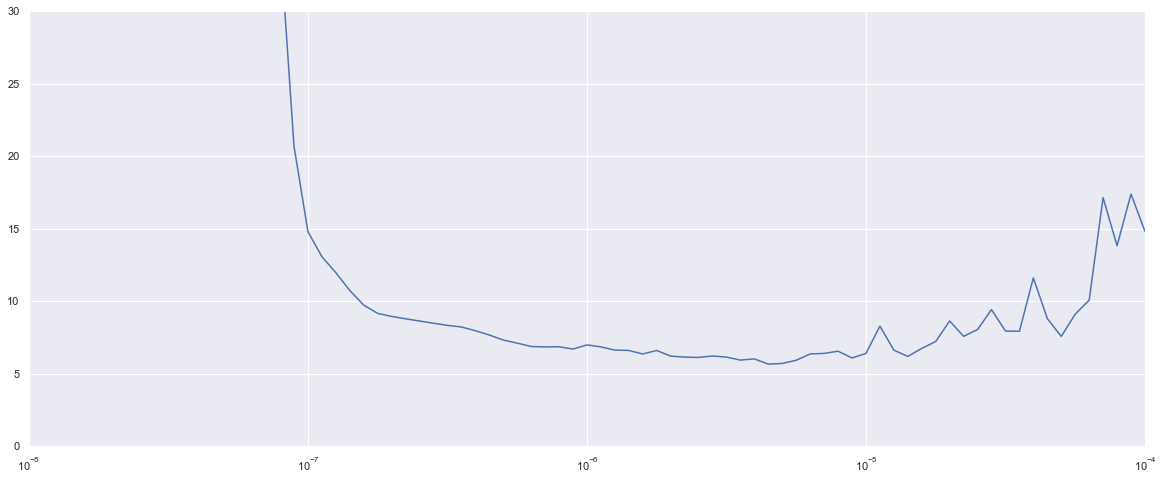

In [21]:
plt.figure(figsize=(20,8))
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

## Final Model

In [22]:
tf.keras.backend.clear_session()
tf.random.set_seed(99)

In [23]:
optimizer = tf.keras.optimizers.SGD(learning_rate=4e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
             optimizer = optimizer,
             metrics = ["mae"])

In [24]:
history = model.fit(trainSet, epochs=500, callbacks=[earlyStop])

Epoch 1/500
31/31 [==============================] - 5s 118ms/step - loss: 18.6670 - mae: 19.1618
Epoch 2/500
31/31 [==============================] - 4s 116ms/step - loss: 13.2111 - mae: 13.7060
Epoch 3/500
31/31 [==============================] - 4s 113ms/step - loss: 8.8578 - mae: 9.3455
Epoch 4/500
31/31 [==============================] - 4s 114ms/step - loss: 10.0070 - mae: 10.4971
Epoch 5/500
31/31 [==============================] - 4s 118ms/step - loss: 7.7706 - mae: 8.2565
Epoch 6/500
31/31 [==============================] - 4s 118ms/step - loss: 8.0376 - mae: 8.5250
Epoch 7/500
31/31 [==============================] - 4s 118ms/step - loss: 12.5273 - mae: 13.0169
Epoch 8/500
31/31 [==============================] - 4s 112ms/step - loss: 11.0946 - mae: 11.5841
Epoch 9/500
31/31 [==============================] - 4s 118ms/step - loss: 13.8576 - mae: 14.3505
Epoch 10/500
31/31 [==============================] - 4s 115ms/step - loss: 14.8768 - mae: 15.3688
Epoch 11/500
31/31 [=====

31/31 [==============================] - 4s 122ms/step - loss: 5.0503 - mae: 5.5340
Epoch 86/500
31/31 [==============================] - 4s 117ms/step - loss: 5.2236 - mae: 5.7000
Epoch 87/500
31/31 [==============================] - 4s 113ms/step - loss: 5.2502 - mae: 5.7339
Epoch 88/500
31/31 [==============================] - 4s 121ms/step - loss: 5.6527 - mae: 6.1406
Epoch 89/500
31/31 [==============================] - 4s 118ms/step - loss: 5.7426 - mae: 6.2263
Epoch 90/500
31/31 [==============================] - 4s 120ms/step - loss: 5.2170 - mae: 5.6986
Epoch 91/500
31/31 [==============================] - 4s 117ms/step - loss: 5.2135 - mae: 5.6898
Epoch 92/500
31/31 [==============================] - 4s 121ms/step - loss: 4.9774 - mae: 5.4539
Epoch 93/500
31/31 [==============================] - 4s 117ms/step - loss: 4.7325 - mae: 5.2137
Epoch 94/500
31/31 [==============================] - 4s 117ms/step - loss: 5.4946 - mae: 5.9726
Epoch 95/500
31/31 [=======================

31/31 [==============================] - 4s 117ms/step - loss: 4.9610 - mae: 5.4405
Epoch 169/500
31/31 [==============================] - 4s 116ms/step - loss: 5.3155 - mae: 5.7965
Epoch 170/500
31/31 [==============================] - 4s 116ms/step - loss: 6.2527 - mae: 6.7342
Epoch 171/500
31/31 [==============================] - 4s 115ms/step - loss: 5.0165 - mae: 5.4970
Epoch 172/500
31/31 [==============================] - 4s 120ms/step - loss: 4.7677 - mae: 5.2434
Epoch 173/500
31/31 [==============================] - 4s 115ms/step - loss: 4.6812 - mae: 5.1592
Epoch 174/500
31/31 [==============================] - 4s 114ms/step - loss: 4.8166 - mae: 5.2957
Epoch 175/500
31/31 [==============================] - 4s 114ms/step - loss: 4.6605 - mae: 5.1404
Epoch 176/500
31/31 [==============================] - 4s 113ms/step - loss: 4.6956 - mae: 5.1737
Epoch 177/500
31/31 [==============================] - 4s 115ms/step - loss: 5.9301 - mae: 6.4164
Epoch 178/500
31/31 [=============

31/31 [==============================] - 4s 118ms/step - loss: 5.1246 - mae: 5.6046
Epoch 252/500
31/31 [==============================] - 4s 118ms/step - loss: 4.8410 - mae: 5.3190
Epoch 253/500
31/31 [==============================] - 4s 117ms/step - loss: 4.7314 - mae: 5.2049
Epoch 254/500
31/31 [==============================] - 4s 118ms/step - loss: 5.0705 - mae: 5.5504
Epoch 255/500
31/31 [==============================] - 4s 116ms/step - loss: 4.6718 - mae: 5.1528
Epoch 256/500
31/31 [==============================] - 4s 114ms/step - loss: 4.6147 - mae: 5.0907
Epoch 257/500
31/31 [==============================] - 4s 116ms/step - loss: 4.3874 - mae: 4.8647
Epoch 258/500
31/31 [==============================] - 4s 118ms/step - loss: 4.1906 - mae: 4.6682
Epoch 259/500
31/31 [==============================] - 4s 119ms/step - loss: 4.4130 - mae: 4.8862
Epoch 260/500
31/31 [==============================] - 4s 116ms/step - loss: 4.1098 - mae: 4.5816
Epoch 261/500
31/31 [=============

31/31 [==============================] - 4s 115ms/step - loss: 4.1452 - mae: 4.6192
Epoch 335/500
31/31 [==============================] - 4s 111ms/step - loss: 4.2032 - mae: 4.6803
Epoch 336/500
31/31 [==============================] - 4s 111ms/step - loss: 4.1948 - mae: 4.6748
Epoch 337/500
31/31 [==============================] - 4s 115ms/step - loss: 4.1553 - mae: 4.6325
Epoch 338/500
31/31 [==============================] - 4s 112ms/step - loss: 4.9342 - mae: 5.4115
Epoch 339/500
31/31 [==============================] - 4s 113ms/step - loss: 4.3786 - mae: 4.8545
Epoch 340/500
31/31 [==============================] - 4s 113ms/step - loss: 3.9437 - mae: 4.4183
Epoch 341/500
31/31 [==============================] - 4s 112ms/step - loss: 3.8567 - mae: 4.3274
Epoch 342/500
31/31 [==============================] - 4s 113ms/step - loss: 3.9440 - mae: 4.4197
Epoch 343/500
31/31 [==============================] - 4s 113ms/step - loss: 3.9906 - mae: 4.4629
Epoch 344/500
31/31 [=============

31/31 [==============================] - 4s 114ms/step - loss: 3.9572 - mae: 4.4307
Epoch 418/500
31/31 [==============================] - 4s 116ms/step - loss: 3.9667 - mae: 4.4402
Epoch 419/500
31/31 [==============================] - 4s 114ms/step - loss: 4.3862 - mae: 4.8558
Epoch 420/500
31/31 [==============================] - 4s 116ms/step - loss: 4.0600 - mae: 4.5388
Epoch 421/500
31/31 [==============================] - 4s 113ms/step - loss: 4.4196 - mae: 4.8976
Epoch 422/500
31/31 [==============================] - 4s 114ms/step - loss: 4.1196 - mae: 4.5934
Epoch 423/500
31/31 [==============================] - 4s 113ms/step - loss: 3.8208 - mae: 4.2928
Epoch 424/500
31/31 [==============================] - 4s 113ms/step - loss: 4.3364 - mae: 4.8151
Epoch 425/500
31/31 [==============================] - 4s 112ms/step - loss: 3.6711 - mae: 4.1379
Epoch 426/500
31/31 [==============================] - 4s 111ms/step - loss: 3.9798 - mae: 4.4579
Epoch 427/500
31/31 [=============

31/31 [==============================] - 4s 118ms/step - loss: 3.8296 - mae: 4.3041


In [25]:
forecast = []
for time in range(len(series) - windowSize):
    forecast.append(model.predict(series[time: time+windowSize][np.newaxis]))
    
forecast = forecast[splitTime-windowSize:]
results = np.array(forecast)[:, 0, 0]

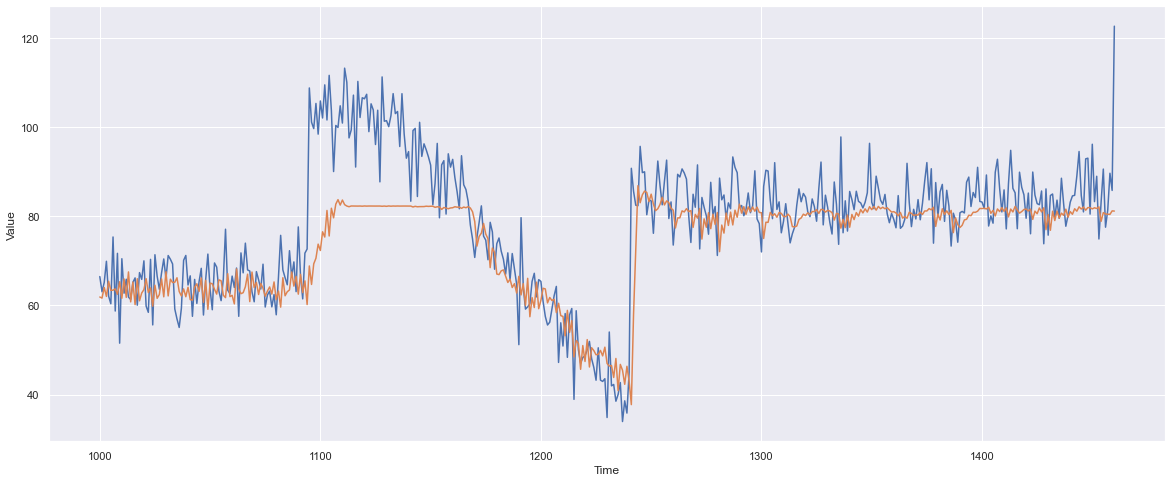

In [26]:
plt.figure(figsize=(20,8))
plotSeries(timeValid, xValid)
plotSeries(timeValid, results)

In [27]:
score = tf.keras.metrics.mean_absolute_error(xValid, results).numpy()
print(score)

7.0842013
